In [1]:
#!/usr/bin/env python3
#/Users/anushree/Desktop/SledLab/data analysis/preprocessing_eyedata.ipynb
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 18 14:41 2025

@author: anushreeganesh
"""

'\nCreated on Fri Apr 18 14:41 2025\n\n@author: anushreeganesh\n'

In [2]:
import scipy.io
import numpy as np
from sklearn.metrics import r2_score

mat = scipy.io.loadmat('KalmanDecoder.mat')

In [3]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'P_0', 'R_test', 'R_train', 'X_test', 'X_train', 'x_0'])

In [4]:
np.shape(mat['R_test']) #113 neurons, 1000 timesteps

(113, 1000)

In [5]:
np.shape(mat['X_test']) #5 

(5, 1000)

In [7]:
#Question 1:
# saving matrices from dictionary key-value pairs
X1 = mat['X_train'][:, 1:-1]
X2 = mat['X_train'][:, 2:]
R_train = mat['R_train']
X_train = mat['X_train']
R_test = mat['R_test']
X_test = mat['X_test']
#X1_transpose = np.transpose(X1) for 1D arrays ://

## Finding theta = {A, W, H, Q}:
#A = (X2 * X1_transpose) * np.inverse(X1 * X1_transpose) ## need to use linear algebra operands (error: operands could not be broadcast together)
#state transition equations:
A = X2 @ X1.T @ np.linalg.inv(X1 @ X1.T)
W = ((X2 - (A@X1)) @ ((X2 - (A@X1)).T)) / X1.shape[1]
#sensory observation equations:
H = R_train @ (X_train.T)@ np.linalg.inv(X_train @ (X_train.T))
Q = ((R_train - (H @ X_train))@((R_train - (H @ X_train)).T))/ X_train.shape[1]

#intialising: 
x_0 = mat['x_0'] 
P_0 = mat['P_0']
# print(np.shape(np.squeeze(x_0)))
# print(np.shape(P_0))
# print(R_test.shape[1])
timesteps = R_test.shape[1] #thouisand
decoded_x = np.zeros((5, 1000))
x_prev = np.squeeze(x_0)
P_prev = P_0

#decoding loop:
for t in range(timesteps):
    x_est = A @ x_prev
    C_est = (A @ P_prev @ (A.T)) + W
    K_est = C_est @ (H.T) @ np.linalg.inv((H @ C_est @ (H.T))+ Q) #kalman gain
    r_current = R_test[:,t] 
    P_next = (np.eye(5) - K_est @ H) @ C_est
    x_next = x_est + (K_est @ (r_current - H @ x_est))
    decoded_x[:,t] = np.squeeze(x_next)
    x_prev = x_next
    P_prev = P_next

#print(np.shape(decoded_x))

#r-square:

r2_xpos = r2_score(X_test[1,:], decoded_x[1, :])
r2_ypos = r2_score(X_test[2,:], decoded_x[2, :])
r2_xvel = r2_score(X_test[3,:], decoded_x[3, :])
r2_yvel = r2_score(X_test[4,:], decoded_x[4, :])

print(r2_xpos,r2_ypos,r2_xvel,r2_yvel)



0.8915243500050349 0.9097471622204264 0.681852130548493 0.6307714272836484


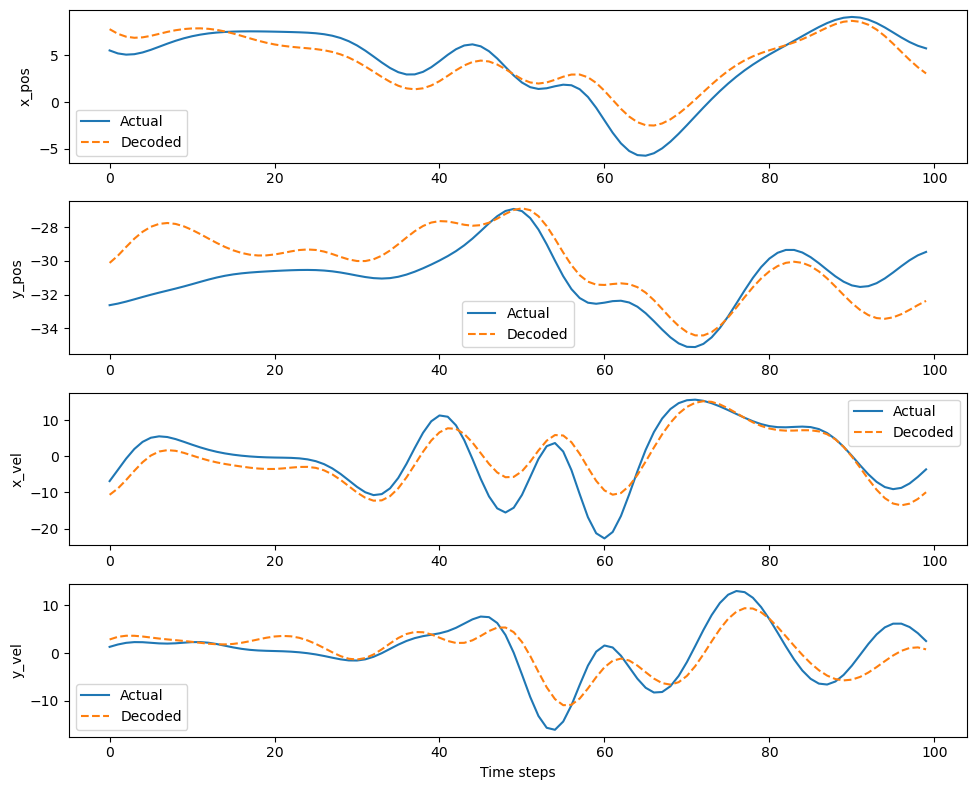

In [10]:
# Q1 plotting: 
import matplotlib.pyplot as plt

timesteps = 100

fig, axs = plt.subplots(4, 1, figsize=(10, 8))

labels = ['x_pos', 'y_pos', 'x_vel', 'y_vel']

for i in range(4):
    axs[i].plot(X_test[i+1, :timesteps], label='Actual')
    axs[i].plot(decoded_x[i+1, :timesteps], label='Decoded', linestyle='--')
    axs[i].set_ylabel(labels[i])
    axs[i].legend()

plt.xlabel('Time steps')
plt.tight_layout()
plt.show()

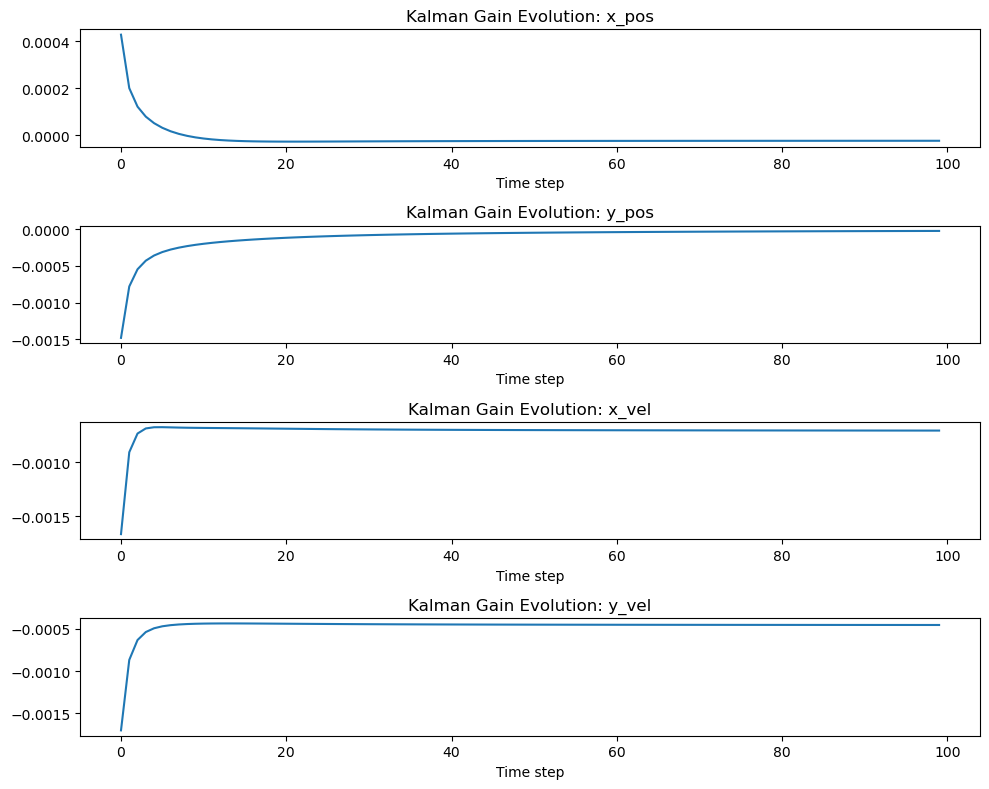

In [12]:
#Question 2:
# saving matrices from dictionary key-value pairs
X1 = mat['X_train'][:, 1:-1]
X2 = mat['X_train'][:, 2:]
R_train = mat['R_train']
X_train = mat['X_train']
R_test = mat['R_test']
X_test = mat['X_test']
#X1_transpose = np.transpose(X1) for 1D arrays ://

## Finding theta = {A, W, H, Q}:
#A = (X2 * X1_transpose) * np.inverse(X1 * X1_transpose) ## need to use linear algebra operands (error: operands could not be broadcast together)
#state transition equations:
A = X2 @ X1.T @ np.linalg.inv(X1 @ X1.T)
W = ((X2 - (A@X1)) @ ((X2 - (A@X1)).T)) / X1.shape[1]
#sensory observation equations:
H = R_train @ (X_train.T)@ np.linalg.inv(X_train @ (X_train.T))
Q = ((R_train - (H @ X_train))@((R_train - (H @ X_train)).T))/ X_train.shape[1]

#intialising: 
x_0 = mat['x_0'] 
P_0 = mat['P_0']
# print(np.shape(np.squeeze(x_0)))
# print(np.shape(P_0))
# print(R_test.shape[1])
timesteps = R_test.shape[1] #thouisand
decoded_x = np.zeros((5, 1000))
kalman_gains = np.zeros((5,113,timesteps))
x_prev = np.squeeze(x_0)
P_prev = P_0

#decoding loop:
for t in range(timesteps):
    x_est = A @ x_prev
    C_est = (A @ P_prev @ (A.T)) + W
    K_est = C_est @ (H.T) @ np.linalg.inv((H @ C_est @ (H.T))+ Q) #kalman gain
    r_current = R_test[:,t] 
    P_next = (np.eye(5) - K_est @ H) @ C_est
    x_next = x_est + (K_est @ (r_current - H @ x_est))
    decoded_x[:,t] = np.squeeze(x_next)
    kalman_gains[:,:,t] = K_est
    x_prev = x_next
    P_prev = P_next

#print(np.shape(decoded_x))
avg_kalman_gain = np.mean(kalman_gains, axis =1)

import matplotlib.pyplot as plt

time = np.arange(100)  # first 100 time steps

fig, axs = plt.subplots(4, 1, figsize=(10, 8))
labels = ['x_pos', 'y_pos', 'x_vel', 'y_vel']

for i in range(4):
    axs[i].plot(time, avg_kalman_gain[i+1, :100])
    axs[i].set_xlabel('Time step')
    axs[i].set_title(f'Kalman Gain Evolution: {labels[i]}')

plt.tight_layout()
plt.show()

0.8915243398471324 0.9097470330333565 0.681852105767754 0.630771443002617


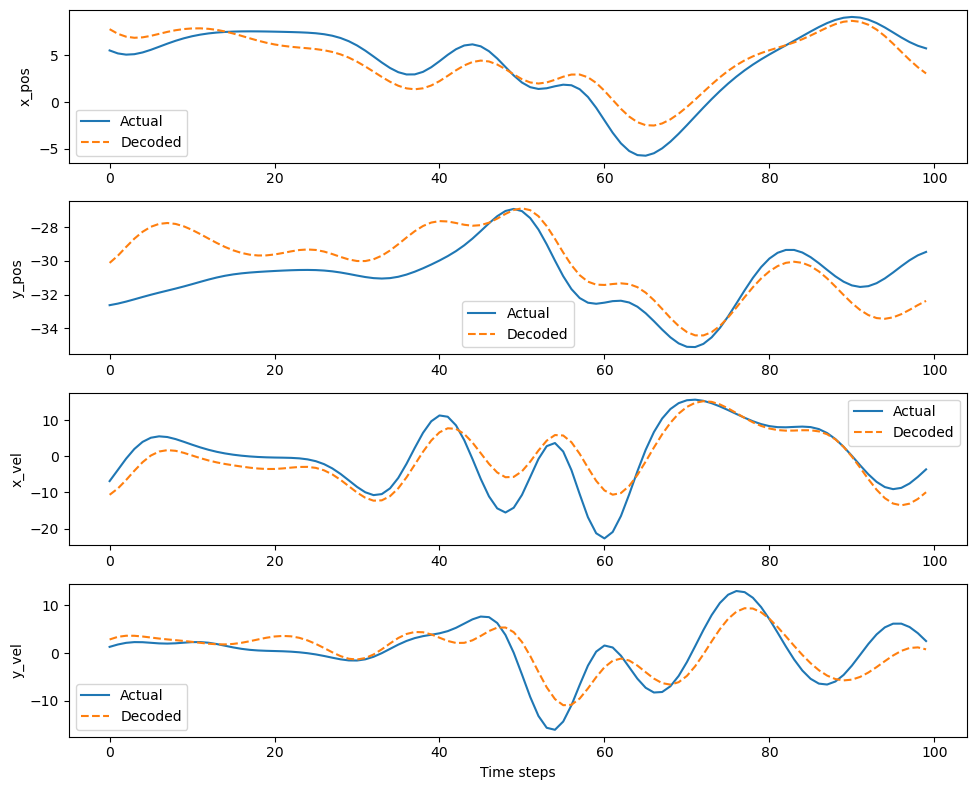

In [14]:
#Question 3.1: x_0 = 0, p_0 = 1000
# saving matrices from dictionary key-value pairs
X1 = mat['X_train'][:, 1:-1]
X2 = mat['X_train'][:, 2:]
R_train = mat['R_train']
X_train = mat['X_train']
R_test = mat['R_test']
X_test = mat['X_test']
#X1_transpose = np.transpose(X1) for 1D arrays ://

## Finding theta = {A, W, H, Q}:
#A = (X2 * X1_transpose) * np.inverse(X1 * X1_transpose) ## need to use linear algebra operands (error: operands could not be broadcast together)
#state transition equations:
A = X2 @ X1.T @ np.linalg.inv(X1 @ X1.T)
W = ((X2 - (A@X1)) @ ((X2 - (A@X1)).T)) / X1.shape[1]
#sensory observation equations:
H = R_train @ (X_train.T)@ np.linalg.inv(X_train @ (X_train.T))
Q = ((R_train - (H @ X_train))@((R_train - (H @ X_train)).T))/ X_train.shape[1]

#intialising: 
x_0 = mat['x_0'] 
P_0 = mat['P_0']
# print(np.shape(np.squeeze(x_0)))
# print(np.shape(P_0))
# print(R_test.shape[1])
timesteps = R_test.shape[1] #thouisand
decoded_x = np.zeros((5, 1000))
x_prev = np.zeros(5)
P_prev = P_0

#decoding loop:
for t in range(timesteps):
    x_est = A @ x_prev
    C_est = (A @ P_prev @ (A.T)) + W
    K_est = C_est @ (H.T) @ np.linalg.inv((H @ C_est @ (H.T))+ Q) #kalman gain
    r_current = R_test[:,t] 
    P_next = (np.eye(5) - K_est @ H) @ C_est
    x_next = x_est + (K_est @ (r_current - H @ x_est))
    decoded_x[:,t] = np.squeeze(x_next)
    x_prev = x_next
    P_prev = P_next

#print(np.shape(decoded_x))

#r-square:

r2_xpos = r2_score(X_test[1,:], decoded_x[1, :])
r2_ypos = r2_score(X_test[2,:], decoded_x[2, :])
r2_xvel = r2_score(X_test[3,:], decoded_x[3, :])
r2_yvel = r2_score(X_test[4,:], decoded_x[4, :])

print(r2_xpos,r2_ypos,r2_xvel,r2_yvel)
# Q3.2 plotting: 
import matplotlib.pyplot as plt

timesteps = 100

fig, axs = plt.subplots(4, 1, figsize=(10, 8))

labels = ['x_pos', 'y_pos', 'x_vel', 'y_vel']

for i in range(4):
    axs[i].plot(X_test[i+1, :timesteps], label='Actual')
    axs[i].plot(decoded_x[i+1, :timesteps], label='Decoded', linestyle='--')
    axs[i].set_ylabel(labels[i])
    axs[i].legend()

plt.xlabel('Time steps')
plt.tight_layout()
plt.show()

0.891698017731656 0.9103568020300876 0.6815667769640055 0.6308191648279944


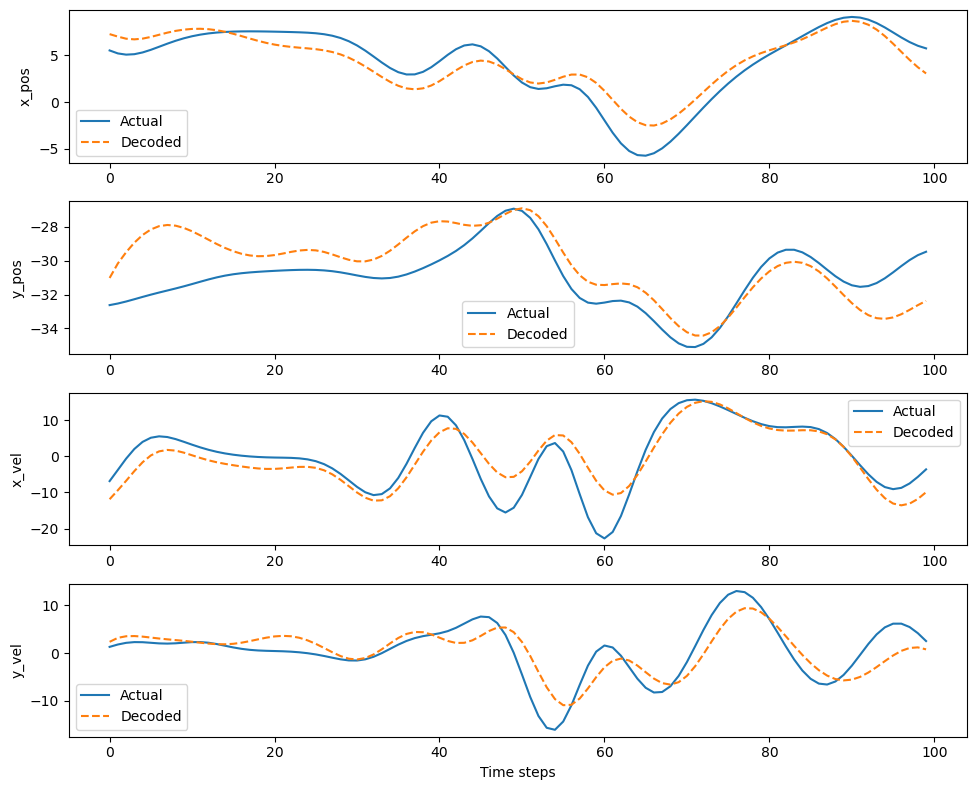

In [29]:
#Question 3.2: x_0 = -100, p_0 = 1000
# saving matrices from dictionary key-value pairs
X1 = mat['X_train'][:, 1:-1]
X2 = mat['X_train'][:, 2:]
R_train = mat['R_train']
X_train = mat['X_train']
R_test = mat['R_test']
X_test = mat['X_test']
#X1_transpose = np.transpose(X1) for 1D arrays ://

## Finding theta = {A, W, H, Q}:
#A = (X2 * X1_transpose) * np.inverse(X1 * X1_transpose) ## need to use linear algebra operands (error: operands could not be broadcast together)
#state transition equations:
A = X2 @ X1.T @ np.linalg.inv(X1 @ X1.T)
W = ((X2 - (A@X1)) @ ((X2 - (A@X1)).T)) / X1.shape[1]
#sensory observation equations:
H = R_train @ (X_train.T)@ np.linalg.inv(X_train @ (X_train.T))
Q = ((R_train - (H @ X_train))@((R_train - (H @ X_train)).T))/ X_train.shape[1]

#intialising: 
# x_0 = mat['x_0'] 
# P_0 = mat['P_0']
# print(np.shape(np.squeeze(x_0)))
# print(np.shape(P_0))
# print(R_test.shape[1])
timesteps = R_test.shape[1] #thouisand
decoded_x = np.zeros((5, 1000))
x_0 = np.full((5,), -100)
P_0 = 1000 * np.eye(5)       

# Initialize
x_prev =  np.full((5,), -100)  
P_prev = P_0 
#decoding loop:
for t in range(timesteps):
    x_est = A @ x_prev
    C_est = (A @ P_prev @ (A.T)) + W
    K_est = C_est @ (H.T) @ np.linalg.inv((H @ C_est @ (H.T))+ Q) #kalman gain
    r_current = R_test[:,t] 
    P_next = (np.eye(5) - K_est @ H) @ C_est
    x_next = x_est + (K_est @ (r_current - H @ x_est))
    decoded_x[:,t] = np.squeeze(x_next)
    x_prev = x_next
    P_prev = P_next

#print(np.shape(decoded_x))

#r-square:

r2_xpos = r2_score(X_test[1,:], decoded_x[1, :])
r2_ypos = r2_score(X_test[2,:], decoded_x[2, :])
r2_xvel = r2_score(X_test[3,:], decoded_x[3, :])
r2_yvel = r2_score(X_test[4,:], decoded_x[4, :])

print(r2_xpos,r2_ypos,r2_xvel,r2_yvel)
# Q3.2 plotting: 
import matplotlib.pyplot as plt

timesteps = 100

fig, axs = plt.subplots(4, 1, figsize=(10, 8))

labels = ['x_pos', 'y_pos', 'x_vel', 'y_vel']

for i in range(4):
    axs[i].plot(X_test[i+1, :timesteps], label='Actual')
    axs[i].plot(decoded_x[i+1, :timesteps], label='Decoded', linestyle='--')
    axs[i].set_ylabel(labels[i])
    axs[i].legend()

plt.xlabel('Time steps')
plt.tight_layout()
plt.show()

0.8920636597477436 0.1484417156374499 0.656821439313716 0.562911637814189


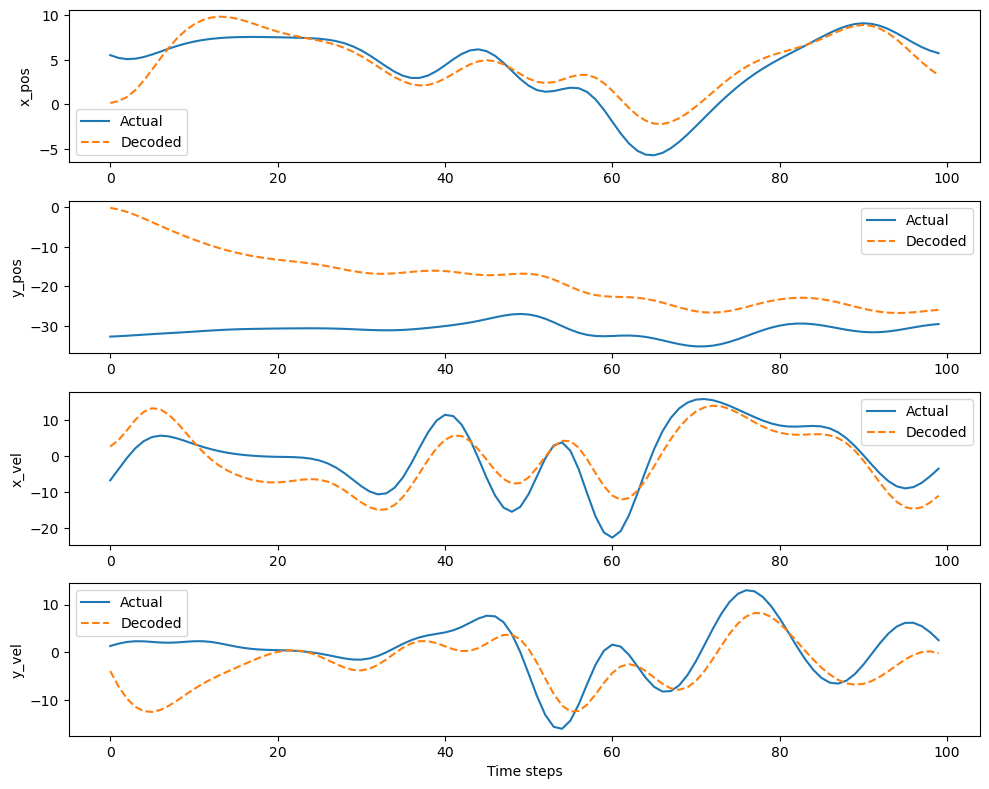

In [16]:
#Question 3.3: x_0 = 0, p_0 = 0.01
# saving matrices from dictionary key-value pairs
X1 = mat['X_train'][:, 1:-1]
X2 = mat['X_train'][:, 2:]
R_train = mat['R_train']
X_train = mat['X_train']
R_test = mat['R_test']
X_test = mat['X_test']
#X1_transpose = np.transpose(X1) for 1D arrays ://

## Finding theta = {A, W, H, Q}:
#A = (X2 * X1_transpose) * np.inverse(X1 * X1_transpose) ## need to use linear algebra operands (error: operands could not be broadcast together)
#state transition equations:
A = X2 @ X1.T @ np.linalg.inv(X1 @ X1.T)
W = ((X2 - (A@X1)) @ ((X2 - (A@X1)).T)) / X1.shape[1]
#sensory observation equations:
H = R_train @ (X_train.T)@ np.linalg.inv(X_train @ (X_train.T))
Q = ((R_train - (H @ X_train))@((R_train - (H @ X_train)).T))/ X_train.shape[1]

#intialising: 
x_0 = mat['x_0'] 
P_0 = mat['P_0']
# print(np.shape(np.squeeze(x_0)))
# print(np.shape(P_0))
# print(R_test.shape[1])
timesteps = R_test.shape[1] #thouisand
decoded_x = np.zeros((5, 1000))
x_prev = np.squeeze(x_0)
P_prev = 0.01 * np.eye(5)

#decoding loop:
for t in range(timesteps):
    x_est = A @ x_prev
    C_est = (A @ P_prev @ (A.T)) + W
    K_est = C_est @ (H.T) @ np.linalg.inv((H @ C_est @ (H.T))+ Q) #kalman gain
    r_current = R_test[:,t] 
    P_next = (np.eye(5) - K_est @ H) @ C_est
    x_next = x_est + (K_est @ (r_current - H @ x_est))
    decoded_x[:,t] = np.squeeze(x_next)
    x_prev = x_next
    P_prev = P_next

#print(np.shape(decoded_x))

#r-square:

r2_xpos = r2_score(X_test[1,:], decoded_x[1, :])
r2_ypos = r2_score(X_test[2,:], decoded_x[2, :])
r2_xvel = r2_score(X_test[3,:], decoded_x[3, :])
r2_yvel = r2_score(X_test[4,:], decoded_x[4, :])

print(r2_xpos,r2_ypos,r2_xvel,r2_yvel)
# Q3.3 plotting: 
import matplotlib.pyplot as plt

timesteps = 100

fig, axs = plt.subplots(4, 1, figsize=(10, 8))

labels = ['x_pos', 'y_pos', 'x_vel', 'y_vel']

for i in range(4):
    axs[i].plot(X_test[i+1, :timesteps], label='Actual')
    axs[i].plot(decoded_x[i+1, :timesteps], label='Decoded', linestyle='--')
    axs[i].set_ylabel(labels[i])
    axs[i].legend()

plt.xlabel('Time steps')
plt.tight_layout()
plt.show()

-3.295320381491095 -0.561193246417911 -0.5140760866660317 -0.6541349051927361


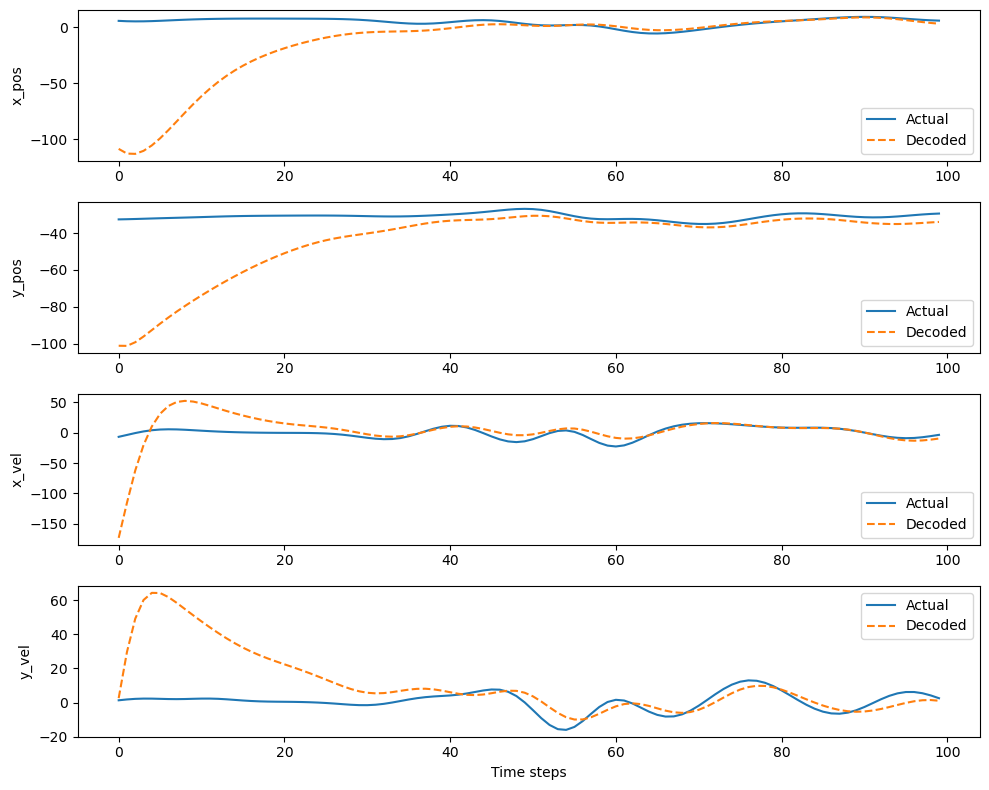

In [19]:
#Question 3.4: x_0 = -100, p_0 = 0.01
# saving matrices from dictionary key-value pairs
X1 = mat['X_train'][:, 1:-1]
X2 = mat['X_train'][:, 2:]
R_train = mat['R_train']
X_train = mat['X_train']
R_test = mat['R_test']
X_test = mat['X_test']
#X1_transpose = np.transpose(X1) for 1D arrays ://

## Finding theta = {A, W, H, Q}:
#A = (X2 * X1_transpose) * np.inverse(X1 * X1_transpose) ## need to use linear algebra operands (error: operands could not be broadcast together)
#state transition equations:
A = X2 @ X1.T @ np.linalg.inv(X1 @ X1.T)
W = ((X2 - (A@X1)) @ ((X2 - (A@X1)).T)) / X1.shape[1]
#sensory observation equations:
H = R_train @ (X_train.T)@ np.linalg.inv(X_train @ (X_train.T))
Q = ((R_train - (H @ X_train))@((R_train - (H @ X_train)).T))/ X_train.shape[1]

#intialising: 
x_0 = mat['x_0'] 
P_0 = mat['P_0']
# print(np.shape(np.squeeze(x_0)))
# print(np.shape(P_0))
# print(R_test.shape[1])
timesteps = R_test.shape[1] #thouisand
decoded_x = np.zeros((5, 1000))
x_prev = np.full(5,-100)
P_prev = 0.01 * np.eye(5)

#decoding loop:
for t in range(timesteps):
    x_est = A @ x_prev
    C_est = (A @ P_prev @ (A.T)) + W
    K_est = C_est @ (H.T) @ np.linalg.inv((H @ C_est @ (H.T))+ Q) #kalman gain
    r_current = R_test[:,t] 
    P_next = (np.eye(5) - K_est @ H) @ C_est
    x_next = x_est + (K_est @ (r_current - H @ x_est))
    decoded_x[:,t] = np.squeeze(x_next)
    x_prev = x_next
    P_prev = P_next

#print(np.shape(decoded_x))

#r-square:

r2_xpos = r2_score(X_test[1,:], decoded_x[1, :])
r2_ypos = r2_score(X_test[2,:], decoded_x[2, :])
r2_xvel = r2_score(X_test[3,:], decoded_x[3, :])
r2_yvel = r2_score(X_test[4,:], decoded_x[4, :])

print(r2_xpos,r2_ypos,r2_xvel,r2_yvel)
# Q3.4 plotting: 
import matplotlib.pyplot as plt

timesteps = 100

fig, axs = plt.subplots(4, 1, figsize=(10, 8))

labels = ['x_pos', 'y_pos', 'x_vel', 'y_vel']

for i in range(4):
    axs[i].plot(X_test[i+1, :timesteps], label='Actual')
    axs[i].plot(decoded_x[i+1, :timesteps], label='Decoded', linestyle='--')
    axs[i].set_ylabel(labels[i])
    axs[i].legend()

plt.xlabel('Time steps')
plt.tight_layout()
plt.show()

Running for Q scale = 0.01


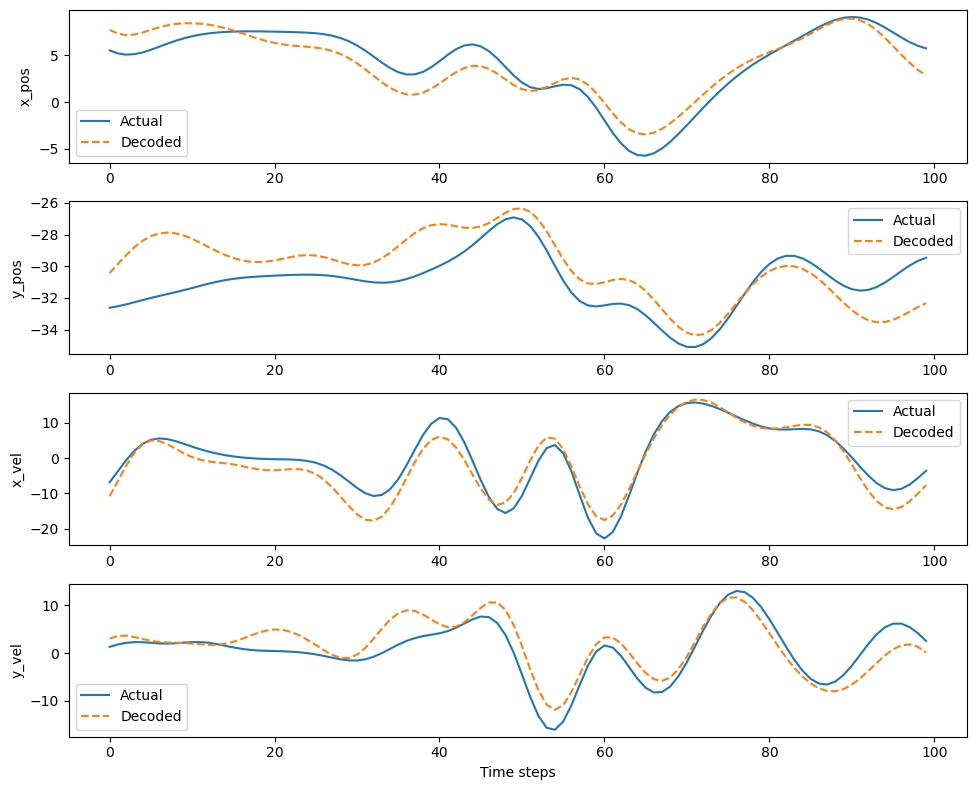

Running for Q scale = 0.1


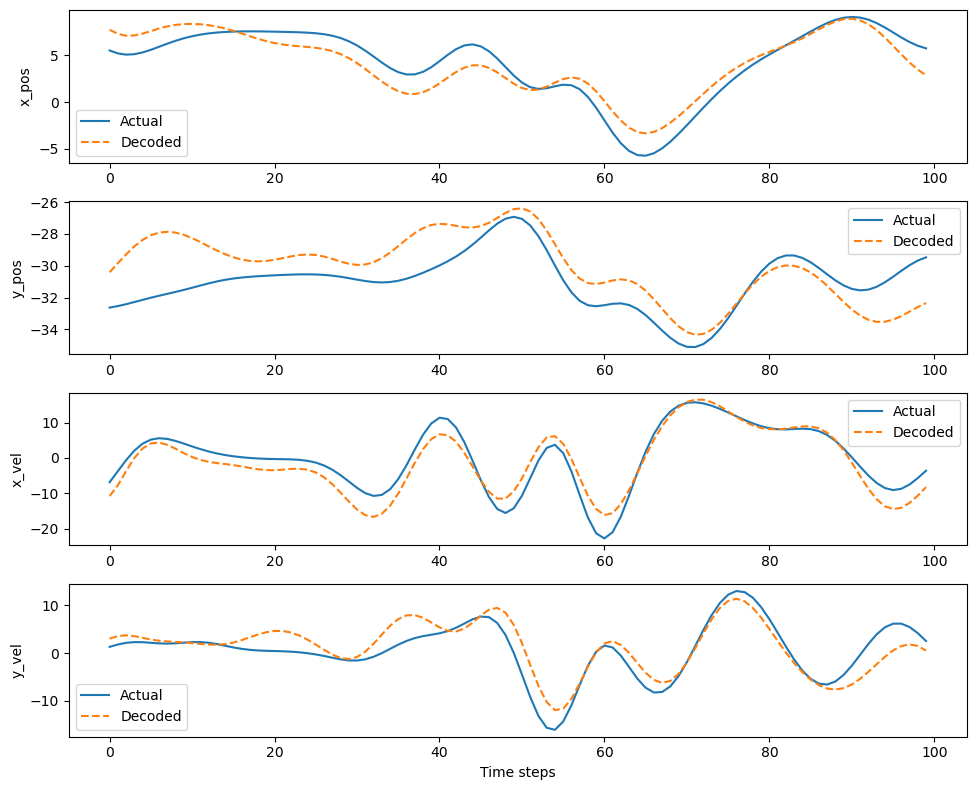

Running for Q scale = 1


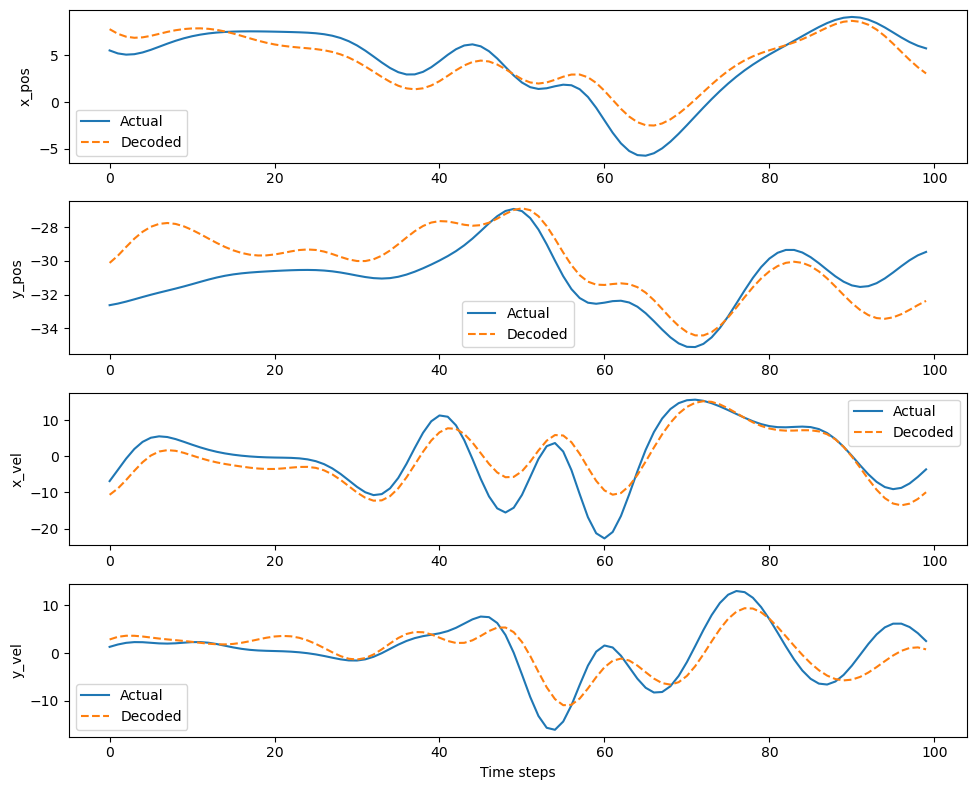

Running for Q scale = 10


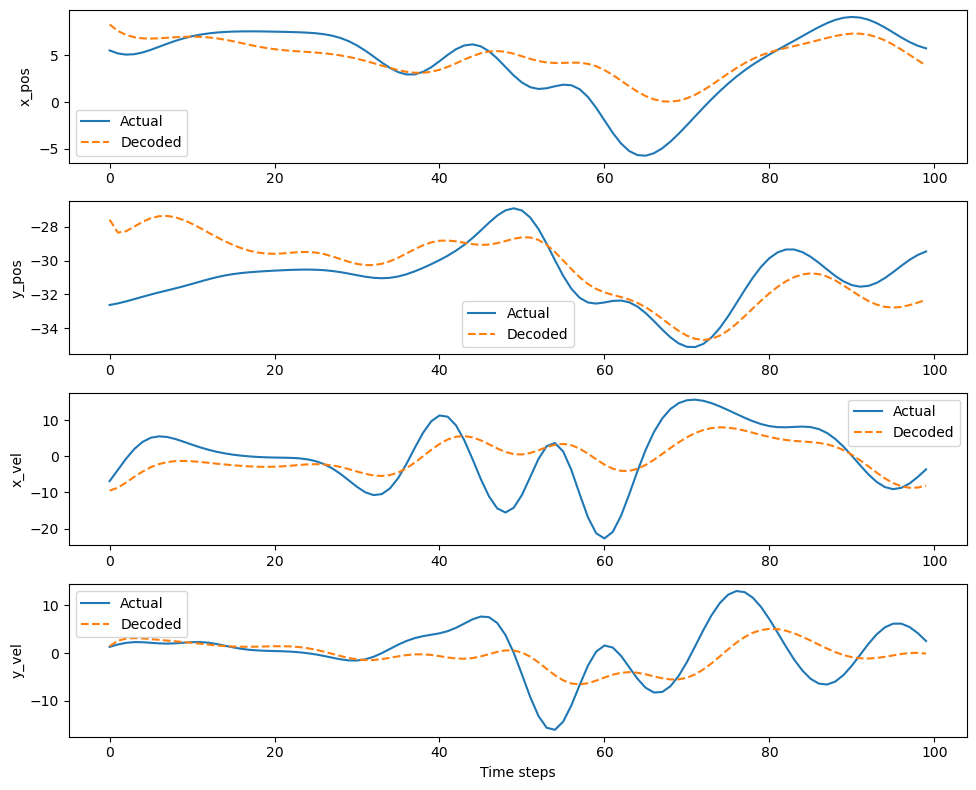

Running for Q scale = 100


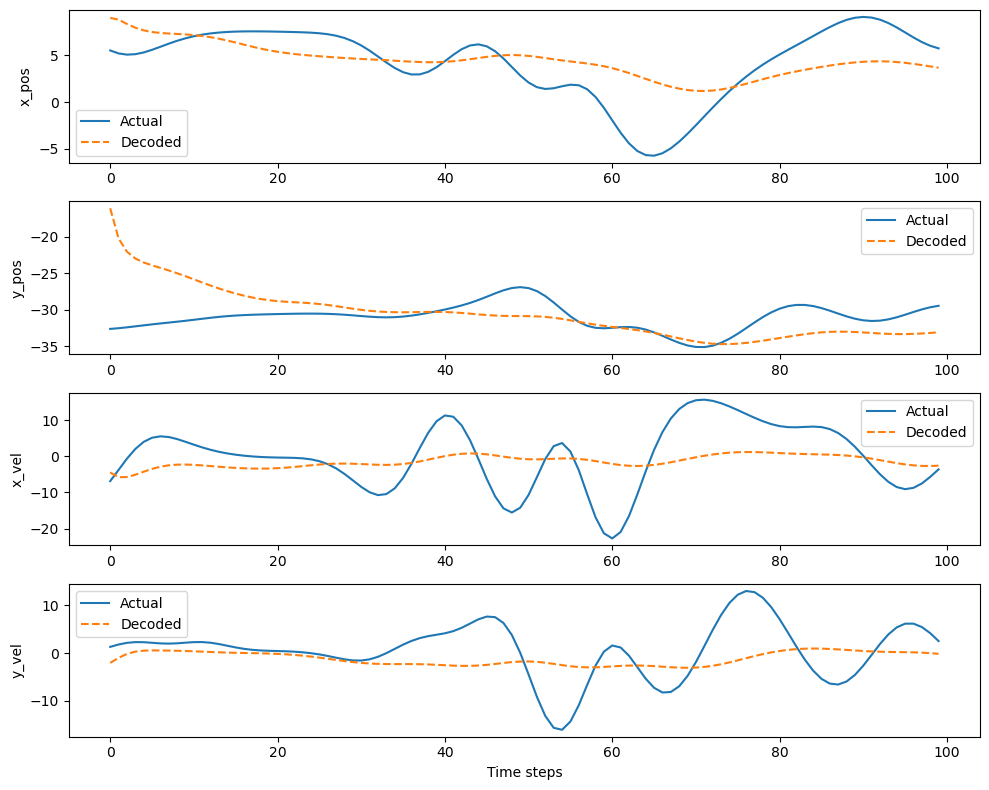

In [38]:
#Question 4:
# saving matrices from dictionary key-value pairs
X1 = mat['X_train'][:, 1:-1]
X2 = mat['X_train'][:, 2:]
R_train = mat['R_train']
X_train = mat['X_train']
R_test = mat['R_test']
X_test = mat['X_test']
#X1_transpose = np.transpose(X1) for 1D arrays ://

## Finding theta = {A, W, H, Q}:
#A = (X2 * X1_transpose) * np.inverse(X1 * X1_transpose) ## need to use linear algebra operands (error: operands could not be broadcast together)
#state transition equations:
A = X2 @ X1.T @ np.linalg.inv(X1 @ X1.T)
W = ((X2 - (A@X1)) @ ((X2 - (A@X1)).T)) / X1.shape[1]
#sensory observation equations:
H = R_train @ (X_train.T)@ np.linalg.inv(X_train @ (X_train.T))
Q = ((R_train - (H @ X_train))@((R_train - (H @ X_train)).T))/ X_train.shape[1]

#intialising: 
x_0 = mat['x_0'] 
P_0 = mat['P_0']
scales = [0.01, 0.1, 1, 10, 100]

r2_results = []
kalman_gains_all = []

for scale in scales:
    print(f"Running for Q scale = {scale}")
    Q_scaled = scale * Q
    decoded_x = np.zeros((5, R_test.shape[1]))
    x_prev = np.squeeze(x_0)
    P_prev = P_0
    kalman_gains = []
    #decoding loop
    for t in range(R_test.shape[1]):
        x_est = A @ x_prev
        C_est = A @ P_prev @ A.T + W
        
        K_est = C_est @ H.T @ np.linalg.inv(H @ C_est @ H.T + Q_scaled)
        
        r_current = R_test[:, t]

        P_next = (np.eye(5) - K_est @ H) @ C_est
        x_next = x_est + K_est @ (r_current - H @ x_est)

        decoded_x[:, t] = np.squeeze(x_next)

        kalman_gains.append(np.mean(K_est, axis=1))
        x_prev = x_next
        P_prev = P_next

    r2_xpos = r2_score(X_test[1, :], decoded_x[1, :])
    r2_ypos = r2_score(X_test[2, :], decoded_x[2, :])
    r2_xvel = r2_score(X_test[3, :], decoded_x[3, :])
    r2_yvel = r2_score(X_test[4, :], decoded_x[4, :])

    r2_results.append([r2_xpos, r2_ypos, r2_xvel, r2_yvel])
    kalman_gains_all.append(np.array(kalman_gains))
    # timesteps = 100
    # avg_kalman_gain_all = np.mean(kalman_gains_all, axis =1)

    # time = np.arange(100)  # first 100 time steps

    # fig, axs = plt.subplots(4, 1, figsize=(10, 8))
    # labels = ['x_pos', 'y_pos', 'x_vel', 'y_vel']
    
    # for i in range(4):
    #     axs[i].plot(time, avg_kalman_gain[i+1, :100])
    #     axs[i].set_xlabel('Time step')
    #     axs[i].set_title(f'Kalman Gain Evolution: {labels[i]}')
    
    # plt.tight_layout()
    # plt.show()

    fig, axs = plt.subplots(4, 1, figsize=(10, 8))

    labels = ['x_pos', 'y_pos', 'x_vel', 'y_vel']

    for i in range(4):
        axs[i].plot(X_test[i+1, :timesteps], label='Actual')
        axs[i].plot(decoded_x[i+1, :timesteps], label='Decoded', linestyle='--')
        axs[i].set_ylabel(labels[i])
        axs[i].legend()
    
    plt.xlabel('Time steps')
    plt.tight_layout()
    plt.show()

In [35]:
print(r2_results) #cols = xpos, ypos, xvel, yvel; rows = scales

[[0.8913154555505237, 0.9069553540769267, 0.7129988826436457, 0.6563176120156515], [0.8917229077452254, 0.9072590002235432, 0.7372653853129755, 0.6810648921571174], [0.8915243500050349, 0.9097471622204264, 0.681852130548493, 0.6307714272836484], [0.8560551553023148, 0.9045742105608992, 0.3644139195900792, 0.3414811200696696], [0.7241783906791934, 0.7587722645303788, 0.1159791934768506, 0.0842286773409916]]


In [43]:
print(np.shape(kalman_gains_all[0])) #rows = timseteps, cols= kinematic states

(1000, 5)


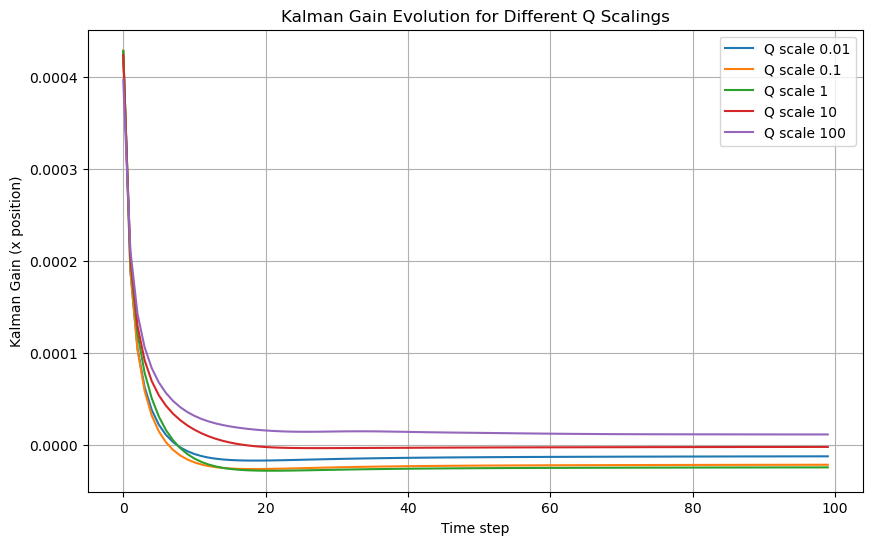

In [45]:
timesteps = 100
time = np.arange(timesteps)

plt.figure(figsize=(10,6))
plt.plot(time, kalman_gains_all[0][:100, 1], label='Q scale 0.01')
plt.plot(time, kalman_gains_all[1][:100, 1], label='Q scale 0.1')
plt.plot(time, kalman_gains_all[2][:100, 1], label='Q scale 1')
plt.plot(time, kalman_gains_all[3][:100, 1], label='Q scale 10')
plt.plot(time, kalman_gains_all[4][:100, 1], label='Q scale 100')

plt.xlabel('Time step')
plt.ylabel('Kalman Gain (x position)')
plt.title('Kalman Gain Evolution for Different Q Scalings')

plt.legend()
plt.grid()
plt.show()


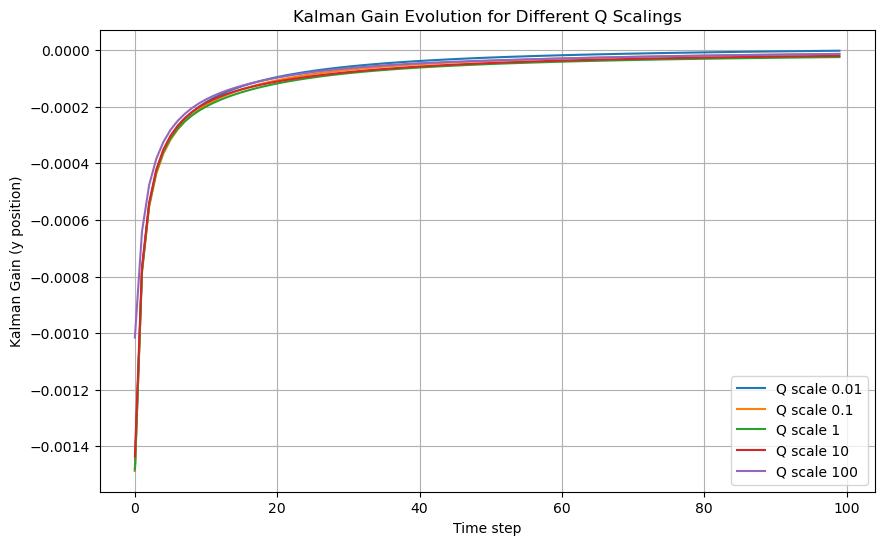

In [50]:
timesteps = 100
time = np.arange(timesteps)

plt.figure(figsize=(10,6))
plt.plot(time, kalman_gains_all[0][:100, 2], label='Q scale 0.01')
plt.plot(time, kalman_gains_all[1][:100, 2], label='Q scale 0.1')
plt.plot(time, kalman_gains_all[2][:100, 2], label='Q scale 1')
plt.plot(time, kalman_gains_all[3][:100, 2], label='Q scale 10')
plt.plot(time, kalman_gains_all[4][:100, 2], label='Q scale 100')

plt.xlabel('Time step')
plt.ylabel('Kalman Gain (y position)')
plt.title('Kalman Gain Evolution for Different Q Scalings')

plt.legend()
plt.grid()
plt.show()

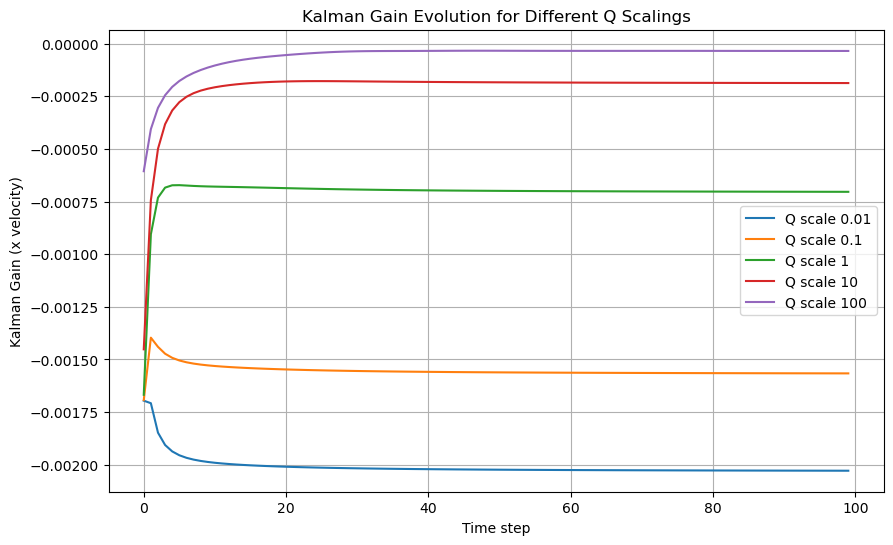

In [46]:
timesteps = 100
time = np.arange(timesteps)

plt.figure(figsize=(10,6))
plt.plot(time, kalman_gains_all[0][:100, 3], label='Q scale 0.01')
plt.plot(time, kalman_gains_all[1][:100, 3], label='Q scale 0.1')
plt.plot(time, kalman_gains_all[2][:100, 3], label='Q scale 1')
plt.plot(time, kalman_gains_all[3][:100, 3], label='Q scale 10')
plt.plot(time, kalman_gains_all[4][:100, 3], label='Q scale 100')

plt.xlabel('Time step')
plt.ylabel('Kalman Gain (x velocity)')
plt.title('Kalman Gain Evolution for Different Q Scalings')

plt.legend()
plt.grid()
plt.show()

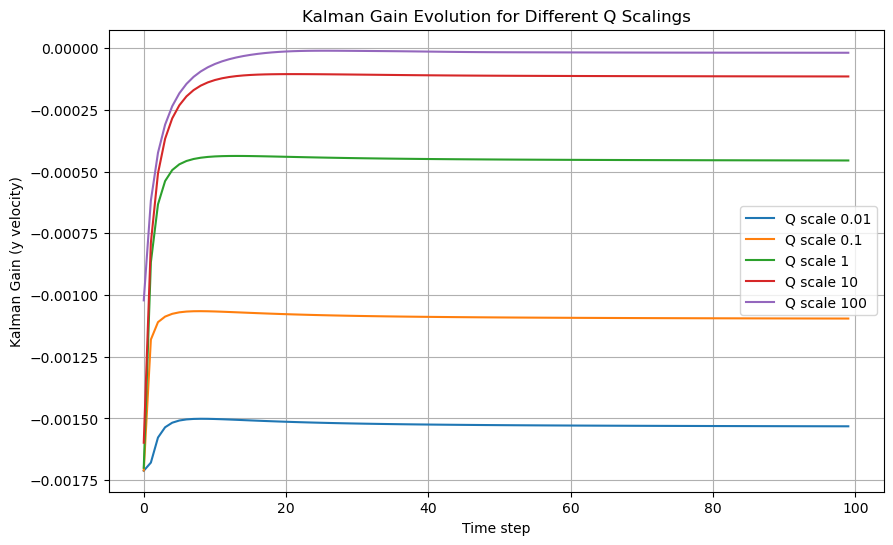

In [48]:
timesteps = 100
time = np.arange(timesteps)

plt.figure(figsize=(10,6))
plt.plot(time, kalman_gains_all[0][:100, 4], label='Q scale 0.01')
plt.plot(time, kalman_gains_all[1][:100, 4], label='Q scale 0.1')
plt.plot(time, kalman_gains_all[2][:100, 4], label='Q scale 1')
plt.plot(time, kalman_gains_all[3][:100, 4], label='Q scale 10')
plt.plot(time, kalman_gains_all[4][:100, 4], label='Q scale 100')

plt.xlabel('Time step')
plt.ylabel('Kalman Gain (y velocity)')
plt.title('Kalman Gain Evolution for Different Q Scalings')

plt.legend()
plt.grid()
plt.show()